<a href="https://colab.research.google.com/github/Chandra0718/Data-Analytics/blob/main/E_commerce_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
public_url = ngrok.connect(8501)
print("Streamlit app is live at:", public_url)

Streamlit app is live at: NgrokTunnel: "https://d39745810acc.ngrok-free.app" -> "http://localhost:8501"


In [92]:
!tail -n 20 /tmp/logs.txt

In [91]:
!streamlit run app.py --server.port 8501 &>/tmp/logs.txt &

In [90]:
!kill -9 $(lsof -t -i:8501) 2>/dev/null || echo "Port 8501 is free"
from pyngrok import ngrok
ngrok.kill()

Port 8501 is free


In [89]:
import psutil

# Kill any process using port 8501
for proc in psutil.process_iter(['pid', 'name']):
    try:
        for conns in proc.connections(kind='inet'):
            if conns.laddr.port == 8501:
                print("Killing process:", proc.info)
                proc.kill()
    except Exception as e: pass

In [88]:
!pip install psutil

In [87]:
code = """print("Streamlit app is live at:", public_url)"""
print(code.encode("utf-8"))

b'print("Streamlit app is live at:", public_url)'


In [95]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA

# ===========================
# LOAD DATA (Upload CSV or Use Sample)
# ===========================
st.sidebar.subheader("📂 Upload Data")
uploaded_file = st.sidebar.file_uploader("/content/cleaned_ecommerce.csv", type=["csv"])

if uploaded_file is not None:
    df = pd.read_csv(uploaded_file)
    # Try to parse Date column if present
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
else:
    st.sidebar.info("Using sample dataset (upload to replace).")
    data = """OrderID,Date,CustomerID,Amount,Category
1,2023-01-01,C001,200,Electronics
2,2023-01-02,C002,150,Fashion
3,2023-01-03,C003,300,Home
4,2023-01-04,C002,250,Electronics
5,2023-01-05,C001,100,Fashion
6,2023-01-06,C004,400,Electronics
7,2023-01-07,C003,200,Fashion
8,2023-01-08,C001,350,Home
9,2023-01-09,C002,220,Electronics"""
    from io import StringIO
    df = pd.read_csv(StringIO(data))
    df["Date"] = pd.to_datetime(df["Date"])

# ===========================
# STREAMLIT APP
# ===========================
st.title("📊 E-commerce Sales Analytics Dashboard")

page = st.sidebar.radio("Go to:",
                        ["📂 Data Overview",
                         "👥 RFM Segmentation",
                         "🛒 Market Basket Analysis",
                         "📈 Sales Forecasting"])

# ----------------------------
# PAGE 1: Data Overview
# ----------------------------
if page == "📂 Data Overview":
    st.subheader("📂 Raw Data")
    st.write(df.head())

    # KPIs
    st.subheader("📌 KPIs")
    col1, col2 = st.columns(2)
    col1.metric("Total Sales", f"${df['Amount'].sum():,.0f}")
    col2.metric("Unique Customers", df["CustomerID"].nunique())

    # Sales Trend
    if "Date" in df.columns:
        st.subheader("📈 Daily Sales Trend")
        daily_sales = df.groupby("Date")["Amount"].sum()
        st.line_chart(daily_sales)

    # Sales by Category
    if "Category" in df.columns:
        st.subheader("🛍 Sales by Category")
        category_sales = df.groupby("Category")["Amount"].sum()
        st.bar_chart(category_sales)

# ----------------------------
# PAGE 2: RFM Segmentation
# ----------------------------
elif page == "👥 RFM Segmentation":
    if "Date" in df.columns:
        st.subheader("👥 Customer Segmentation (RFM)")
        snapshot_date = df["Date"].max() + timedelta(days=1)
        rfm = df.groupby("CustomerID").agg({
            "Date": lambda x: (snapshot_date - x.max()).days,
            "OrderID": "count",
            "Amount": "sum"
        }).rename(columns={"Date":"Recency","OrderID":"Frequency","Amount":"Monetary"})
        st.write(rfm)
    else:
        st.warning("Your dataset needs a 'Date' column for RFM.")

# ----------------------------
# PAGE 3: Market Basket Analysis
# ----------------------------
elif page == "🛒 Market Basket Analysis":
    if "Category" in df.columns and "OrderID" in df.columns:
        st.subheader("🛒 Market Basket Analysis")

        # User controls
        min_support = st.slider("Minimum Support", 0.01, 0.5, 0.05, 0.01)
        min_threshold = st.slider("Minimum Lift Threshold", 0.1, 5.0, 1.0, 0.1)

        # Create Basket Matrix
        basket = df.groupby(["OrderID", "Category"])["Amount"].sum().unstack().fillna(0)
        basket = basket.applymap(lambda x: 1 if x > 0 else 0)

        # Run Apriori with user-defined support
        frequent_items = apriori(basket, min_support=min_support, use_colnames=True)

        if frequent_items.empty:
            st.warning("⚠ No frequent itemsets found. Try lowering Minimum Support.")
        else:
            st.write("📌 Frequent Itemsets:")
            st.dataframe(frequent_items)

            # Show top frequent itemsets
            st.bar_chart(frequent_items.set_index("itemsets")["support"].nlargest(10))

            # Association rules
            rules = association_rules(frequent_items, metric="lift", min_threshold=min_threshold)

            if rules.empty:
                st.warning("⚠ No association rules found. Try lowering the Lift Threshold.")
            else:
                st.write("📌 Association Rules:")
                st.dataframe(rules[["antecedents", "consequents", "support", "confidence", "lift"]])

                # Network Graph of Rules
                import networkx as nx
                import matplotlib.pyplot as plt

                G = nx.DiGraph()

                for _, row in rules.iterrows():
                    for antecedent in row["antecedents"]:
                        for consequent in row["consequents"]:
                            G.add_edge(antecedent, consequent, weight=row["lift"])

                plt.figure(figsize=(8, 6))
                pos = nx.spring_layout(G, k=0.5)
                nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold")
                st.pyplot(plt.gcf())
    else:
        st.warning("⚠ Your dataset needs both 'OrderID' and 'Category' columns for Market Basket Analysis.")

# ----------------------------
# PAGE 4: Sales Forecasting
# ----------------------------
elif page == "📈 Sales Forecasting":
    if "Date" in df.columns:
        st.subheader("📈 Sales Forecasting with ARIMA")

        ts = df.groupby("Date")["Amount"].sum()

        try:
            model = ARIMA(ts, order=(1,1,1))
            model_fit = model.fit()
            forecast_steps = 7
            forecast = model_fit.forecast(steps=forecast_steps)

            # Plot
            import matplotlib.pyplot as plt
            fig, ax = plt.subplots()
            ts.plot(ax=ax, label="Historical Sales")
            forecast_index = pd.date_range(ts.index[-1] + timedelta(days=1),
                                           periods=forecast_steps, freq="D")
            forecast_series = pd.Series(forecast, index=forecast_index)
            forecast_series.plot(ax=ax, label="Forecast", color="red")
            ax.legend()
            st.pyplot(fig)

            st.write("🔮 Forecasted Sales:")
            st.write(forecast_series)

        except Exception as e:
            st.error(f"Error in forecasting: {e}")
    else:
        st.warning("Your dataset needs a 'Date' column for Forecasting.")

Overwriting app.py


In [65]:
!ngrok config add-authtoken 31TBufvMDJP1W2cMYP0lycUM4cR_4PpsWb2NwAjzirw2eyEQS

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [42]:
!pip install streamlit pyngrok mlxtend pmdarima

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxorrpmr4/x4wvqui1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxorrpmr4/how_2dbj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88983', 'data', 'file=/tmp/tmpxorrpmr4/x4wvqui1.json', 'init=/tmp/tmpxorrpmr4/how_2dbj.json', 'output', 'file=/tmp/tmpxorrpmr4/prophet_model_ub6pq93/prophet_model-20250819131421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:14:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:14:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


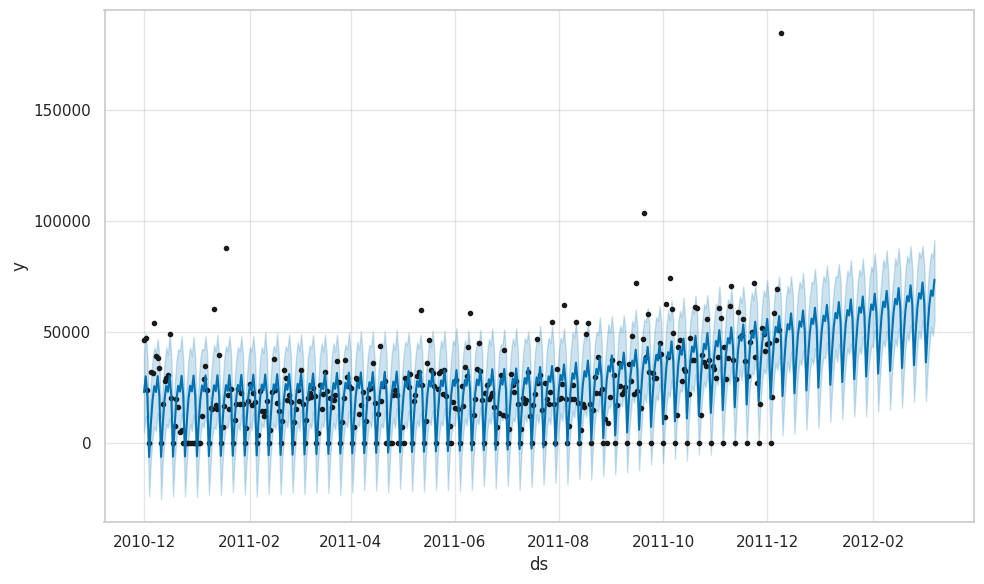

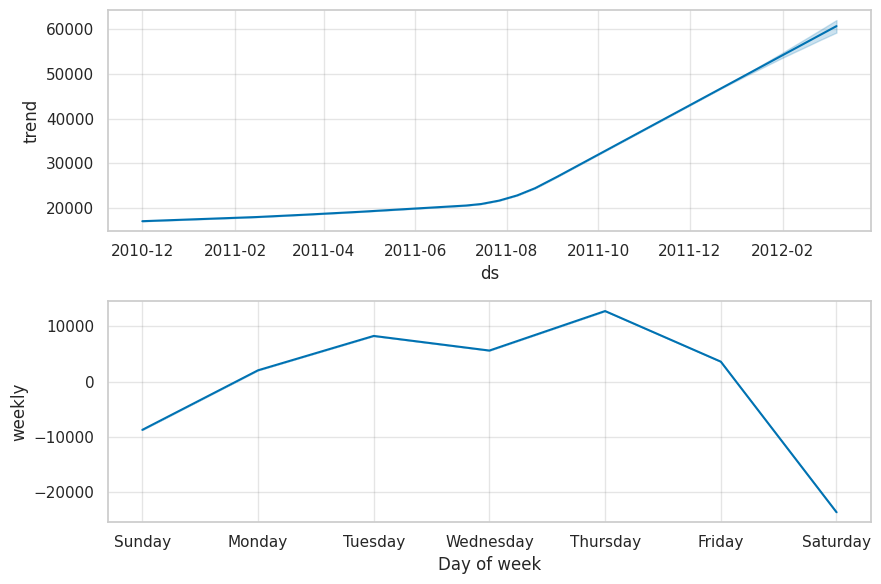

In [43]:
!pip install prophet

from prophet import Prophet

# Prepare data
df_prophet = daily_revenue.reset_index()
df_prophet.columns = ["ds", "y"]

# Train model
model = Prophet()
model.fit(df_prophet)

# Forecast future (next 90 days)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.show()

# Plot seasonality components
fig2 = model.plot_components(forecast)
plt.show()

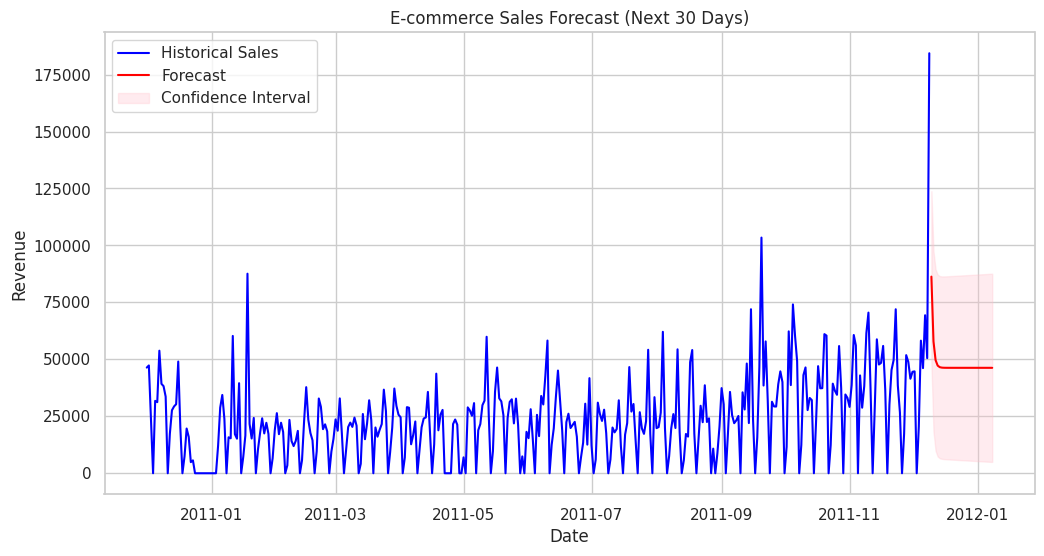

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Step 1: Prepare daily revenue time series
daily_revenue = df.groupby("InvoiceDate")["TotalPrice"].sum().resample("D").sum()

# Step 2: Fit ARIMA model (manual order example: (1,1,1))
model = sm.tsa.ARIMA(daily_revenue, order=(1,1,1))
results = model.fit()

# Step 3: Forecast next 30 days
forecast_steps = 30
forecast = results.get_forecast(steps=forecast_steps)

forecast_index = pd.date_range(
    start=daily_revenue.index[-1] + pd.Timedelta(days=1),
    periods=forecast_steps
)

# Step 4: Plot actuals + forecast
plt.figure(figsize=(12,6))
plt.plot(daily_revenue, label="Historical Sales", color="blue")
plt.plot(forecast_index, forecast.predicted_mean, label="Forecast", color="red")
plt.fill_between(
    forecast_index,
    forecast.conf_int()["lower TotalPrice"],
    forecast.conf_int()["upper TotalPrice"],
    color="pink", alpha=0.3, label="Confidence Interval"
)
plt.title("E-commerce Sales Forecast (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.show()

In [45]:
!pip install mlxtend

import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Step 1: Prepare Basket Data (UK transactions only to simplify)
basket = (df[df['Country'] == "United Kingdom"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

# Step 2: Convert to Binary (0 = not purchased, 1 = purchased)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Step 3: Find Frequent Itemsets using Apriori
frequent_items = apriori(basket, min_support=0.02, use_colnames=True)

# Step 4: Generate Association Rules
rules = association_rules(frequent_items, metric="lift", min_threshold=1)

# Step 5: Sort and Display Top Rules
rules = rules.sort_values("lift", ascending=False)
print(rules.head(10))

/tmp/ipython-input-87472451.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


                                          antecedents  \
71  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...   
74                  (GREEN REGENCY TEACUP AND SAUCER)   
75                   (PINK REGENCY TEACUP AND SAUCER)   
70  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...   
4                   (GREEN REGENCY TEACUP AND SAUCER)   
5                    (PINK REGENCY TEACUP AND SAUCER)   
72  (GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...   
73                 (ROSES REGENCY TEACUP AND SAUCER )   
7                   (GREEN REGENCY TEACUP AND SAUCER)   
6                  (ROSES REGENCY TEACUP AND SAUCER )   

                                          consequents  antecedent support  \
71                  (GREEN REGENCY TEACUP AND SAUCER)            0.023009   
74  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...            0.036766   
75  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...            0.029617   
70                   (PINK REGENCY TEACUP AND SAUCER)           

In [ ]:
import pandas as pd

# Step 1: Calculate RFM metrics
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (df["InvoiceDate"].max() - x.max()).days,  # Recency
    "InvoiceNo": "nunique",  # Frequency
    "TotalPrice": "sum"  # Monetary
})

rfm.columns = ["Recency", "Frequency", "Monetary"]

# Step 2: Assign R, F, M scores (1–5 scale)
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)  # Recent → higher score
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)

# Step 3: Combine RFM score
rfm["RFM_Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
rfm["RFM_Score"] = rfm[["R_Score","F_Score","M_Score"]].sum(axis=1)

# Step 4: Define customer groups
rfm["Customer_Type"] = "Others"
rfm.loc[rfm["RFM_Score"] >= 12, "Customer_Type"] = "Champions"
rfm.loc[(rfm["RFM_Score"] >= 9) & (rfm["RFM_Score"] < 12), "Customer_Type"] = "Loyal Customers"
rfm.loc[(rfm["RFM_Score"] >= 6) & (rfm["RFM_Score"] < 9), "Customer_Type"] = "Potential Loyalist"
rfm.loc[rfm["RFM_Score"] < 6, "Customer_Type"] = "At Risk"

# Step 5: Preview result
print(rfm.head())

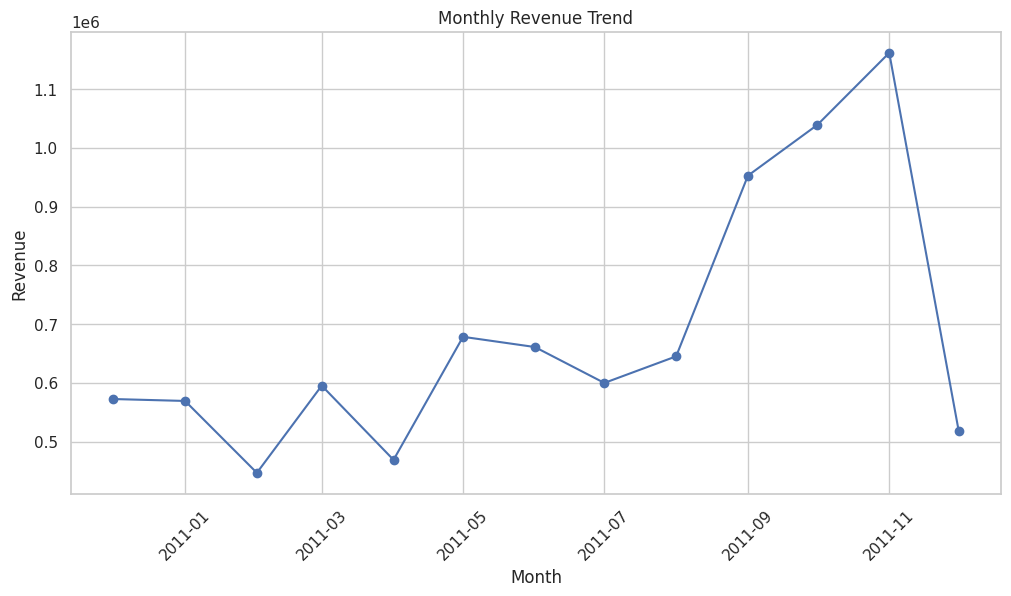

/tmp/ipython-input-2151075148.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")


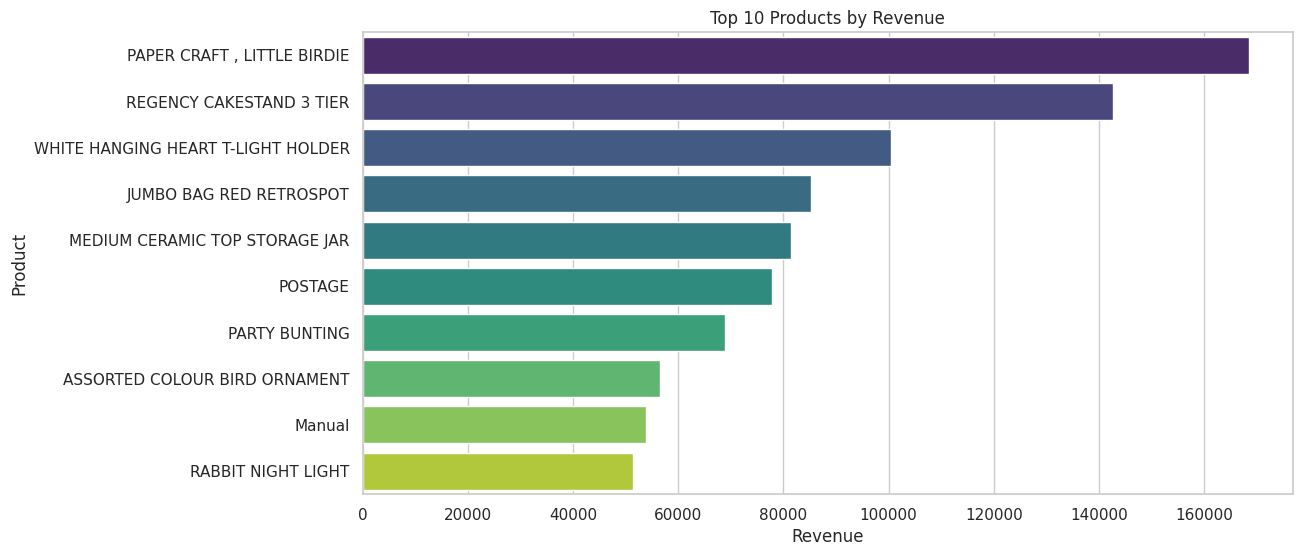

/tmp/ipython-input-2151075148.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_customers.index.astype(str), y=top_customers.values, palette="magma")


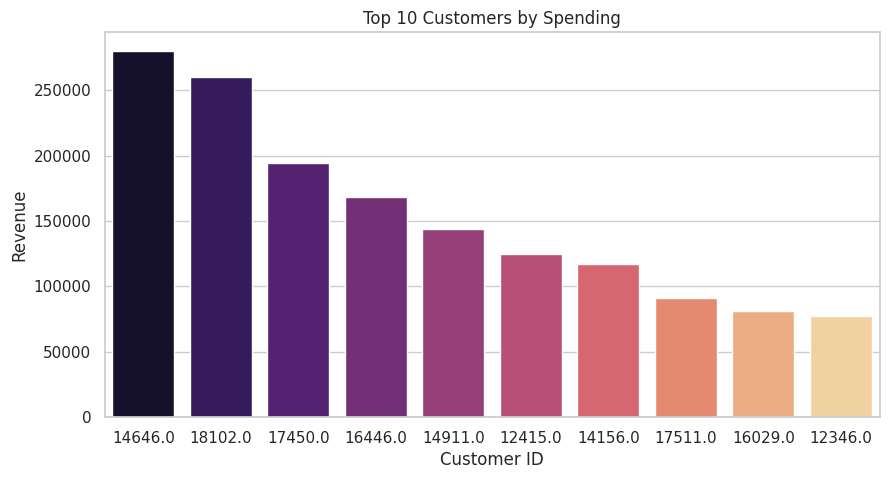

/tmp/ipython-input-2151075148.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="cubehelix")


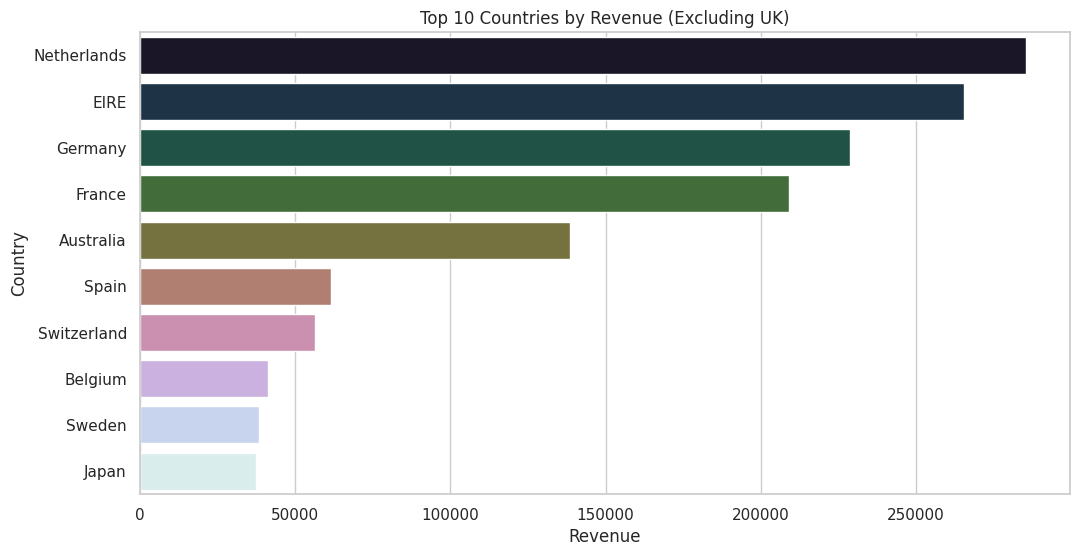

/tmp/ipython-input-2151075148.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=orders_by_day.index, y=orders_by_day.values, palette="coolwarm")


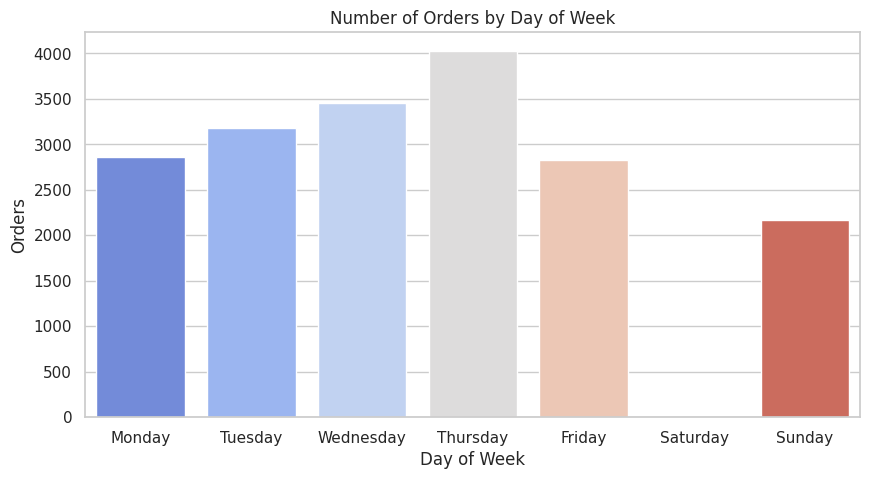

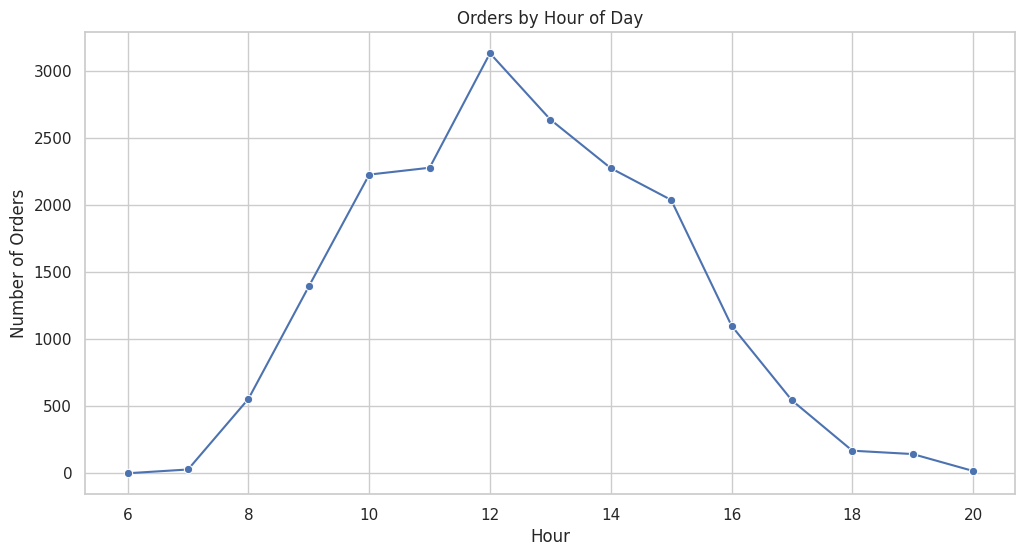

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# ----------------------------
# 1. Monthly Revenue Trend
# ----------------------------
monthly_sales = df.groupby(["Year", "Month"])["TotalPrice"].sum().reset_index()
monthly_sales["YearMonth"] = pd.to_datetime(monthly_sales["Year"].astype(str) + "-" + monthly_sales["Month"].astype(str) + "-01")

plt.figure(figsize=(12,6))
plt.plot(monthly_sales["YearMonth"], monthly_sales["TotalPrice"], marker="o")
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.show()

# ----------------------------
# 2. Top 10 Products by Revenue
# ----------------------------
top_products = df.groupby("Description")["TotalPrice"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Product")
plt.show()

# ----------------------------
# 3. Top 10 Customers by Spending
# ----------------------------
top_customers = df.groupby("CustomerID")["TotalPrice"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_customers.index.astype(str), y=top_customers.values, palette="magma")
plt.title("Top 10 Customers by Spending")
plt.xlabel("Customer ID")
plt.ylabel("Revenue")
plt.show()

# ----------------------------
# 4. Revenue by Country (Top 10 excluding UK)
# ----------------------------
country_sales = df.groupby("Country")["TotalPrice"].sum().sort_values(ascending=False)
top_countries = country_sales.drop("United Kingdom").head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="cubehelix")
plt.title("Top 10 Countries by Revenue (Excluding UK)")
plt.xlabel("Revenue")
plt.ylabel("Country")
plt.show()

# ----------------------------
# 5. Orders by Day of Week
# ----------------------------
orders_by_day = df.groupby("DayOfWeek")["InvoiceNo"].nunique().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

plt.figure(figsize=(10,5))
sns.barplot(x=orders_by_day.index, y=orders_by_day.values, palette="coolwarm")
plt.title("Number of Orders by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Orders")
plt.show()

# ----------------------------
# 6. Orders by Hour of Day
# ----------------------------
orders_by_hour = df.groupby("Hour")["InvoiceNo"].nunique()

plt.figure(figsize=(12,6))
sns.lineplot(x=orders_by_hour.index, y=orders_by_hour.values, marker="o")
plt.title("Orders by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Orders")
plt.show()

In [ ]:
# Step 1: Import libraries
import pandas as pd
import numpy as np

# Step 2: Load dataset
# (update path if needed, e.g., "Ecommerce.csv")
df = pd.read_csv("/content/data.csv", encoding='ISO-8859-1')

# Step 3: Quick look at data
print(df.shape)
print(df.head())
print(df.info())

# Step 4: Handle missing values
# Check missing values
print(df.isnull().sum())

# Remove rows with missing CustomerID (cannot be used for customer analysis)
df = df.dropna(subset=["CustomerID"])

# Step 5: Remove canceled/refunded orders
# Invoice numbers starting with "C" = cancellations
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

# Step 6: Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Step 7: Create new columns
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]  # Revenue column
df["Year"] = df["InvoiceDate"].dt.year
df["Month"] = df["InvoiceDate"].dt.month
df["DayOfWeek"] = df["InvoiceDate"].dt.day_name()
df["Hour"] = df["InvoiceDate"].dt.hour

# Step 8: Remove negative or zero values
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Step 9: Final check
print(df.describe())
print(df.head())

# Save cleaned data (optional)
df.to_csv("cleaned_ecommerce.csv", index=False)

In [ ]:
print("Unique values in Frequency column:")
print(rfm["Frequency"].value_counts().sort_index())

print("\nUnique values in Monetary column (first 20):")
print(rfm["Monetary"].value_counts().sort_index().head(20))